In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
from scipy.interpolate import Rbf
from src.plot_utils import draw_pitch
from matplotlib import animation
from moviepy.editor import *
import math

## Pitch control 
- Wide open spaces: A statistical technique for measuring space creation in propessional soccer

#### Loading data with velocity

In [2]:
df = pd.read_json('./Data/sample_match_1_with_v.json')

In [3]:
df.head()

,Period,Frame,Time [s],H11_x,H11_y,H1_x,H1_y,H2_x,H2_y,H3_x,...,A10_v_abs,A12_x_v,A12_y_v,A12_v_abs,A13_x_v,A13_y_v,A13_v_abs,A14_x_v,A14_y_v,A14_v_abs
2,1,1,0.04,0.08528,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2,0.08,0.09984,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,2.910703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,3,0.12,0.11856,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,3.028292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,4,0.16,0.12584,32.80184,33.92688,44.41556,35.03448,33.31184,32.18176,...,3.144990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,5,0.20,0.13416,32.80184,33.90088,44.38292,35.01056,33.33224,32.18592,...,3.163107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocessing data

- example (1000th frame)

In [4]:
frame = 1000

In [5]:
df1 = df.loc[:, [i for i in df.columns if 'v' not in i]]
df2 = df.loc[:, [i for i in df.columns if 'v' in i]]
positions = df1[df1['Frame'] == frame].iloc[:,3:].drop(['Ball_x', 'Ball_y'], axis=1).dropna(axis=1).iloc[0,:]
velocities = np.array(df2[df1['Frame'] == frame].drop(['Ball_x_v', 'Ball_y_v', 'Ball_v_abs'], axis=1).dropna(axis=1).iloc[0,:])
points = np.array([[positions[2*i], positions[2*i+1]] for i in range(len(positions)//2)])
velocities = np.array([[velocities[3*i], velocities[3*i+1]] for i in range(len(velocities)//3)])
players = np.array([positions.index[2*i].split('_')[0] for i in range(len(points))])
ball_x, ball_y = df.loc[df['Frame'] == frame, ['Ball_x', 'Ball_y']].values[0]
ball = np.array([ball_x, ball_y])

### Influence function

- using scipy multivariate_normal

In [6]:
mv_gaussian = multivariate_normal([0, 0], [[1, 0], [0, 1]])
x, y = np.mgrid[-1:1:.001, -1:1:.001]

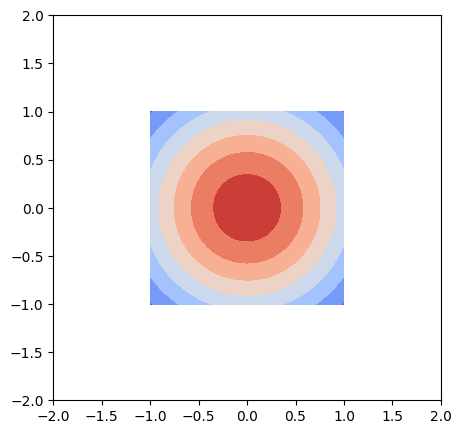

In [7]:
plt.figure(figsize= (5, 5))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.contourf(x, y, mv_gaussian.pdf(np.dstack((x, y))))
plt.set_cmap('coolwarm')

#### Simple influence function

In [8]:
def influence_function(position, location):
    mv_gaussian = multivariate_normal(position, [[12, 0], [0, 12]])
    out = mv_gaussian.pdf(location)
    out /= mv_gaussian.pdf(position)
    return out

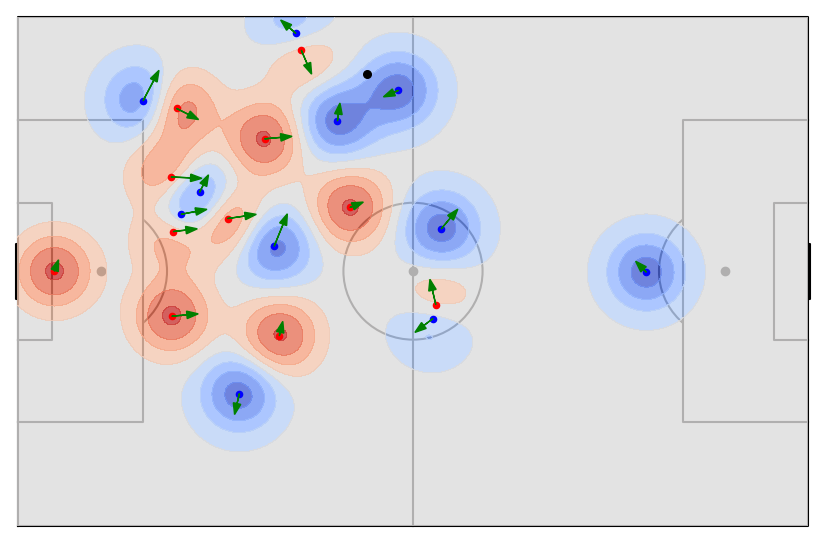

In [9]:
x, y = np.mgrid[0:104:0.1, 0:68:0.1]
locations = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)

s_h, s_a = 0, 0
for i, j in zip(players, points):
    if 'H' in i:        
        s_h += influence_function(j, locations)
    else :
        s_a += influence_function(j, locations)

z = 1 / (1 + np.exp(- s_h + s_a))
fig, ax = draw_pitch('white', 'black')
ax.contourf(x, y, z.reshape(1040, 680), alpha=0.8)
ax.scatter(ball_x, ball_y, s=30, color='black')
for t, p, v in zip(players, points, velocities):
    if 'H' in t:
        color = 'red'
    else:
        color = 'blue'
    ax.scatter(p[0], p[1], c=color, s=20)
    ax.arrow(p[0], p[1], v[0], v[1], color='green', head_width = 1)


#### Wide open spaces: influence function

In [10]:
position = points[7]
velocity = velocities[7]

- Influence radius

In [11]:
def influence_radius(ball, position):
    distance = np.linalg.norm(ball - position)
    output = np.minimum(3/200*(distance)**2 + 4, 10)
    return output

(0.0, 12.0)

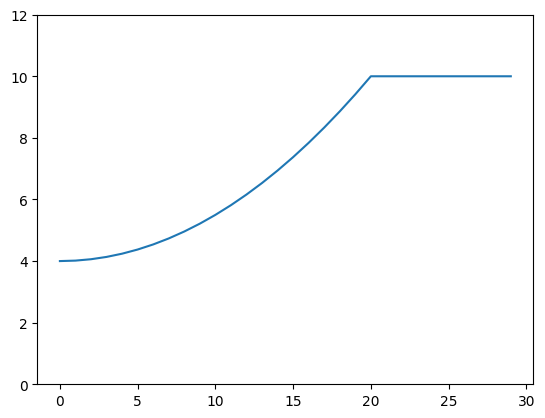

In [12]:
x = np.arange(0, 30, 1)
y = [influence_radius(0, i) for i in x]
plt.plot(x, y)
plt.ylim((0, 12))

In [13]:
mu = position + 0.5*velocity
srat = (velocity[0]**2 + velocity[1]**2)/13**2
theta = np.arctan(velocity[1]/velocity[0])
R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
R_inv = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])
Ri = influence_radius(ball, position)
S = np.array([[(1 + srat)*Ri/2, 0],[0, (1-srat)*Ri/2]])
Cov = np.matmul(np.matmul(np.matmul(R, S), S), R_inv)
new_gaussian = multivariate_normal(mu, Cov)


In [14]:
x, y = np.mgrid[-15:15:0.1, -15:15:0.1]

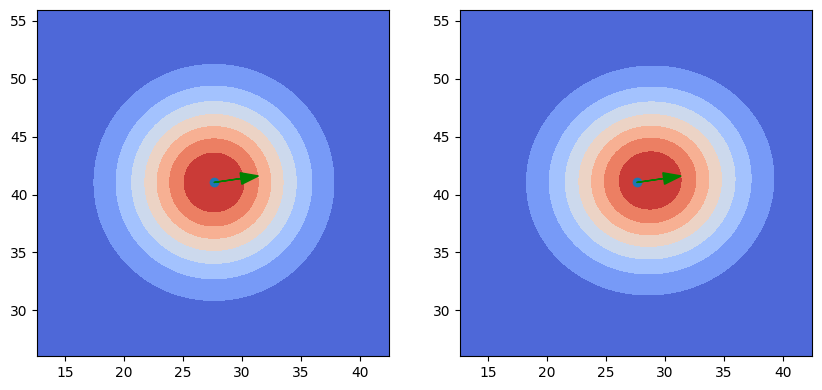

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4.5))

mv_gaussian = multivariate_normal(np.array([position[0], position[1]]), cov=np.array([[25, 0],[0, 25]]))
ax[0].contourf(x+position[0], y+position[1], mv_gaussian.pdf(np.dstack((x+position[0], y+position[1]))))
ax[0].scatter(position[0], position[1])
ax[0].arrow(position[0], position[1], velocity[0], velocity[1], color='green', head_width = 1)



ax[1].contourf(x+position[0], y+position[1], new_gaussian.pdf(np.dstack((x+position[0], y+position[1]))))
ax[1].scatter(position[0], position[1])
ax[1].arrow(position[0], position[1], velocity[0], velocity[1], color='green', head_width = 1)

In [16]:
def influence_function2(position, locations, velocity, ball):
    mu = position + 0.5*velocity
    srat = (velocity[0]**2 + velocity[1]**2)/13**2
    theta = np.arctan(velocity[1]/(velocity[0]+1e-7))
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    R_inv = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])
    Ri = influence_radius(ball, position)
    S = np.array([[(1 + srat)*Ri/2, 0],[0, (1-srat)*Ri/2]])
    Cov = np.matmul(np.matmul(np.matmul(R, S), S), R_inv)
    new_gaussian = multivariate_normal(mu, Cov)
    out = new_gaussian.pdf(locations)
    out /= new_gaussian.pdf(position)
    return out

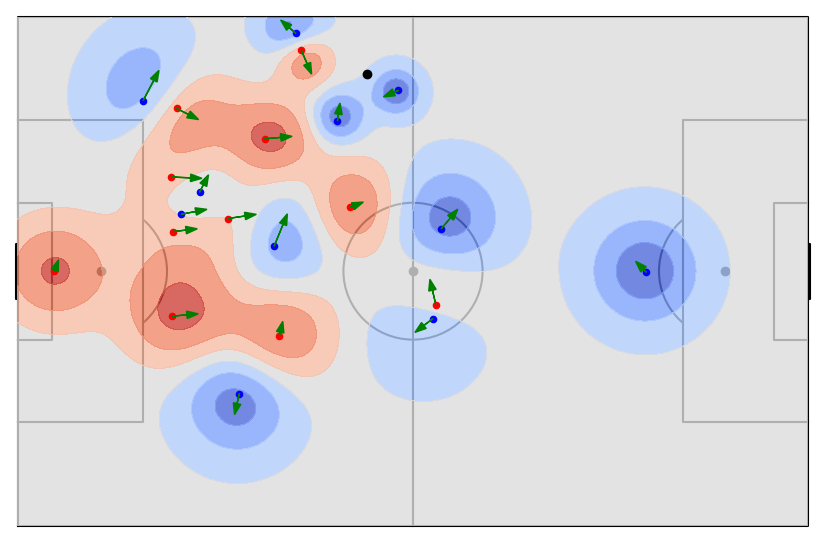

In [17]:
x, y = np.mgrid[0:104:0.1, 0:68:0.1]
locations = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)

s_h, s_a = 0, 0
for i, j, k in zip(players, points, velocities):
    if 'H' in i:        
        s_h += influence_function2(j, locations, k, ball)
    else :
        s_a += influence_function2(j, locations, k, ball)

z = 1 / (1 + np.exp(- s_h + s_a))

fig, ax = draw_pitch('white', 'black')
ax.contourf(x, y, z.reshape(1040, 680), alpha=0.8)
for t, p, v in zip(players, points, velocities):
    if 'H' in t:
        color = 'red'
    else:
        color = 'blue'
    ax.scatter(p[0], p[1], c=color, s=20)
    ax.arrow(p[0], p[1], v[0], v[1], color='green', head_width = 1)

ax.scatter(ball_x, ball_y, color='black')

#### Saving pitch control with video(.mp4)

In [18]:
def plot_pc(frame, figx=None, func_type=0):
    positions = df1[df1['Frame'] == frame].iloc[:,3:].drop(['Ball_x', 'Ball_y'], axis=1).dropna(axis=1).iloc[0,:]
    velocities = np.array(df2[df1['Frame'] == frame].drop(['Ball_x_v', 'Ball_y_v', 'Ball_v_abs'], axis=1).dropna(axis=1).iloc[0,:])
    points = np.array([[positions[2*i], positions[2*i+1]] for i in range(len(positions)//2)])
    velocities = np.array([[velocities[3*i], velocities[3*i+1]] for i in range(len(velocities)//3)])
    players = np.array([positions.index[2*i].split('_')[0] for i in range(len(points))])
    ball_x, ball_y = df.loc[df['Frame'] == frame, ['Ball_x', 'Ball_y']].values[0]
    ball = np.array([ball_x, ball_y])


    x, y = np.mgrid[0:104:0.1, 0:68:0.1]
    locations = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)

    s_h, s_a = 0, 0
    for i, j, k in zip(players, points, velocities):
        if 'H' in i:
            if func_type == 1 and not math.isnan(ball_x):
                s_h += influence_function2(j, locations, k, ball)
            else :
                s_h += influence_function(j, locations)
        else :
            if func_type == 1 and not math.isnan(ball_x):
                s_a += influence_function2(j, locations, k, ball)
            else :
                s_a += influence_function(j, locations)

    z = 1 / (1 + np.exp(- s_h + s_a))

    figobj = []

    if figx == None:
        fig, ax = draw_pitch('white', 'black')
    else :
        fig, ax = figx
    
    figobj.append(ax.contourf(x, y, z.reshape(1040, 680), alpha=0.8))
    for t, p, v in zip(players, points, velocities):
        if 'H' in t:
            color = 'red'
        else:
            color = 'blue'
        figobj.append(ax.scatter(p[0], p[1], c=color, s=20))
        figobj.append(ax.arrow(p[0], p[1], v[0], v[1], color='green', head_width = 1))

    if not math.isnan(ball_x):
        figobj.append(ax.scatter(ball_x, ball_y, color='black'))      
    return fig, ax, figobj                            

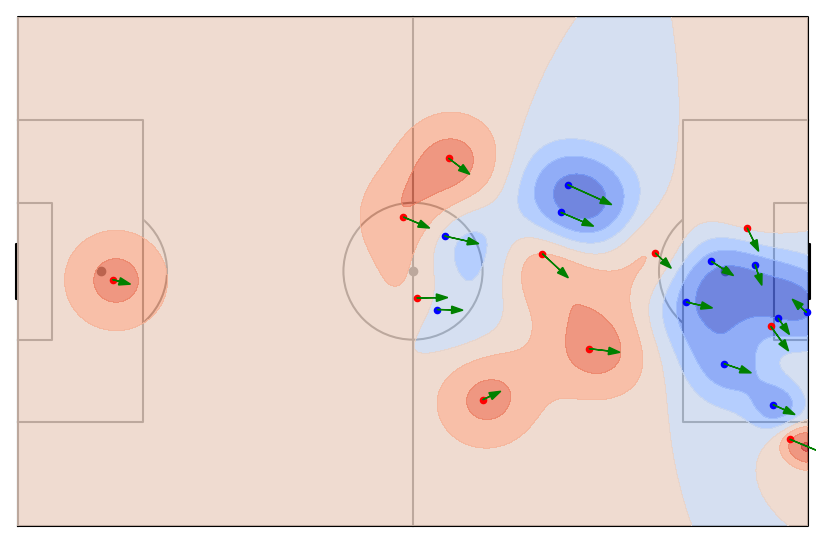

In [19]:
fig, ax, figobj = plot_pc(1420, func_type=1)

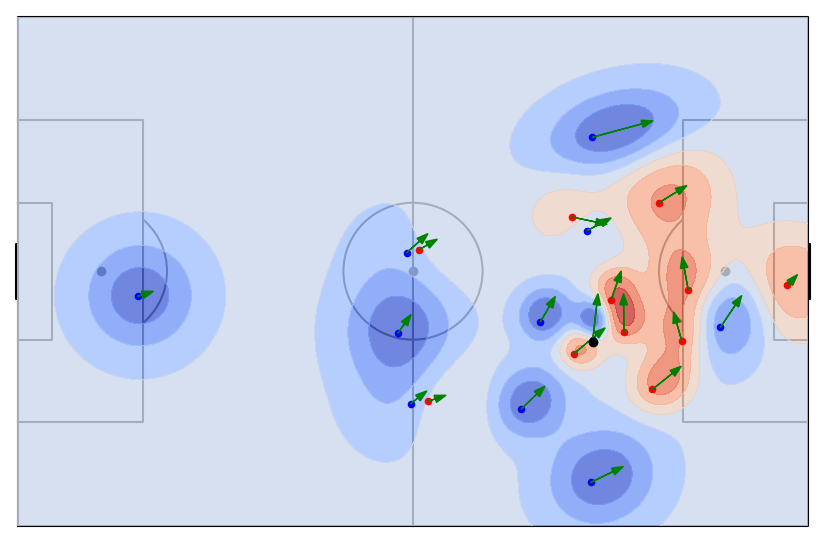

In [20]:
fig, ax, figobj = plot_pc(140020, func_type=1)

In [22]:
def save_plot_pc(
    start_frame, end_frame, fname='test', fps=25, figax=None, func_type = 0
):
    writer = animation.FFMpegWriter(fps=fps)

    if figax is None:
        fig, ax = draw_pitch(pitch='white', line='black')
    else:
        fig, ax = figax

    fig.set_tight_layout(True)

    with writer.saving(fig, fname, dpi=50):
        for frame in np.arange(start_frame, end_frame, 2):
            fig, ax, figobjs = plot_pc(frame, figx = (fig, ax), func_type=func_type)
        
            writer.grab_frame()
            for obj in figobjs:
                if type(obj) == list:
                    obj[0].remove()
                else:
                    obj.remove()

    plt.clf()
    plt.close(fig)

In [23]:
save_plot_pc(600, 700, fname='./PitchControl/Game1_600_700_3.mp4', func_type=2)

In [12]:
VideoFileClip('./PitchControl/Game1_600_1500_1.mp4').speedx(2.5).write_gif('./Gif/pitchcontrol.gif')

MoviePy - Building file ./Gif/pitchcontrol.gif with imageio.
